In [1]:
#https://www.xignite.com/Product/global-interest-rates#/productoverview 
#https://fiscaldata.treasury.gov/api-documentation/

In [157]:
#bring dependencies
from IPython.display import display
from IPython.display import display, HTML
from IPython.display import HTML
from pprint import pprint
from prettytable import PrettyTable
from tqdm import tqdm
from plotly.subplots import make_subplots
from config import api_key_bls
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
import plotly.offline as pyo
import plotly as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import json
import os
import scipy.stats as st
from IPython.display import display, HTML
import seaborn as sns
from scipy.stats import sem


In [158]:
# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(api_key_bls)


BDS0000000000000000110101LQ5 - Business Employment Dynamics
Business Employment Dynamics data are quarterly series of gross job gains and gross job losses statistics for the entire economy. These data track changes in employment at the establishment level, and thus provide a picture of the dynamics underlying aggregate net employment growth statistics.

- 1st plot the line graphic for jobs gain/loss
- 2nd calculated the mean and median for jobs gain/loss
- plot a bar graphic
- top 10 and bottom 10 jobs 2031 forecast




In [159]:
#series
headers = {'Content-type': 'application/json'} #contains info about the message- such as destination

# Submit the list of series as data - payload actual data being transmitted over a network
data = json.dumps({"seriesid": ['BDS0000000000000000110001LQ5',#Business Employment Dynamic - jobs Gain
                                'BDS0000000000000000110004LQ5',#Business Employment Dynamic - jobs loss
                                'BDS0000000000000000120001LQ5',#Business Employment Dynamic - stablishment gain
                                'BDS0000000000000000120004LQ5'#Business Employment Dynamic - stablishment loss
                                
                               ], 
                   'startyear':'2010', 'endyear':'2023',
                   'catalog':True,
                   'annualaverage':True,
                   "registrationkey": api_key_bls}, indent=4)
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
p


<Response [200]>

In [160]:
#create a list to create a DF

list_columns= []


for series in json_data['Results']['series']:

     
    seriesId = series['seriesID']
    print(seriesId)
    
    if 'catalog' in series.keys():
        seasonality = series['catalog']['seasonality']
        survey_name = series['catalog']['survey_name']
        measure_data_type = series['catalog']['measure_data_type']
    
            
        if 'commerce_industry' in series['catalog'].keys():
            commerce_industry = series['catalog']['commerce_industry']
            
        else:
            commerce_industry = None
            
            
        if 'commerce_sector' in series['catalog'].keys():
            commerce_sector = series['catalog']['commerce_sector']
        else:
            commerce_sector = None
     
        if 'area' in series['catalog'].keys():
            area = series['catalog']['area']
        else:
            area = None
    
    
    
       # area= series['catalog']['area']
    else:
        seasonality = None
        survey_name = None
        measure_data_type = None
        commerce_industry = None
        commerce_sector = None
        area= None
    #add all variables & create a list to append to the list above
    
    
    for item in series['data']:
        year = item['year']
        period = item['period']
        periodName = item['periodName']
        value = item['value']
        
        
        list_columns.append([seriesId,seasonality,survey_name,measure_data_type,
                             commerce_industry,commerce_sector,area,year,period,periodName,value])
        
bls_df= pd.DataFrame(list_columns,columns=['seriesId','seasonality','survey_name','measure_data_type',
                             'commerce_industry','commerce_sector','area','year','period','periodName','value'])



bls_df.to_csv("bls.csv", index= False, header=True)





BDS0000000000000000110001LQ5
BDS0000000000000000110004LQ5
BDS0000000000000000120001LQ5
BDS0000000000000000120004LQ5


In [161]:
#BLS job gains/losses from 2010-2023

bed_df = bls_df.loc[(bls_df['seriesId'] == 'BDS0000000000000000110001LQ5') |
                     (bls_df['seriesId'] == 'BDS0000000000000000110004LQ5') ]
                     
bed_df.to_csv("bed.csv", index=False, header=True)


In [162]:
#validate the extracted data against data source https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5
BED=bed_df[['seriesId','survey_name','measure_data_type','commerce_industry','area','year','period','value']]


In [163]:
# replace the row name 'row1' with 'new_row1'
new_bed_df = bed_df.replace({'BDS0000000000000000110001LQ5':'jobs Gains',
                              'BDS0000000000000000110004LQ5':'jobs Losses'}) 


In [164]:
#change column value to Integer
new_bed_df['value'] = new_bed_df['value'].astype(int)


In [165]:
# pitot the data plot 
# https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5

new_bed_df_pivot = new_bed_df.pivot_table(index=['year'], columns='measure_data_type', values='value', aggfunc='sum')
new_bed_df_pivot

measure_data_type,Gross Job Gains,Gross Job Losses
year,,
2010,27113,25859
2011,27576,25484
2012,28122,25611
2013,28406,25967
2014,29271,26342
2015,29787,27303
2016,29729,28106
2017,30166,28145
2018,30394,28402


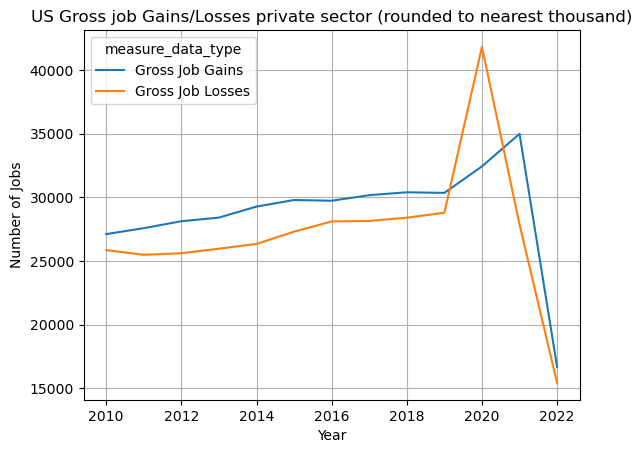

In [166]:
# plot the resulting DataFrame using the plot method
new_bed_df_pivot.plot(kind='line', ylabel='Number of Jobs', xlabel='Year', grid=True)
plt.title('US Gross job Gains/Losses private sector (rounded to nearest thousand)')
plt.savefig("job_G_L.png")
plt.show()

In [167]:
#change column value to Integer
new_bed_df_pivot['Gross Job Gains'] = new_bed_df_pivot['Gross Job Gains'].astype(int)
new_bed_df_pivot['Gross Job Losses'] = new_bed_df_pivot['Gross Job Losses'].astype(int)


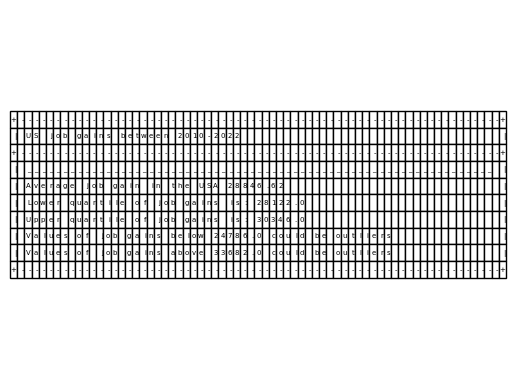

+-------------------------------------------------------------------+
| US job gains between 2010-2022                                    |
+-------------------------------------------------------------------+
| _________________________________________________________________ |
| Average job gain in the USA 28846.62                              |
| Lower quartile of job gains is: 28122.0                           |
| Upper quartile of job gains is: 30346.0                           |
| Values of job gains below 24786.0 could be outliers               |
| Values of job gains above 33682.0 could be outliers               |
+-------------------------------------------------------------------+


In [168]:
import numpy as np

job_gains = new_bed_df_pivot["Gross Job Gains"]
mean_gain = np.mean(job_gains)
quartiles = np.percentile(job_gains, [25, 75])
iqr = quartiles[1] - quartiles[0]

lowerqg = quartiles[0]
upperqg = quartiles[1]

lower_boundg = lowerqg - (1.5 * iqr)
upper_boundg = upperqg + (1.5 * iqr)

# Create a figure with a single subplot
fig, ax = plt.subplots(1, 1)

#Output - Gains
table = PrettyTable()
table.field_names = ["US job gains between 2010-2022"]
table.add_row(["_________________________________________________________________"])
table.add_row([f"Average job gain in the USA {mean_gain:.2f}"])
table.add_row([f"Lower quartile of job gains is: {lowerqg}"])
table.add_row([f"Upper quartile of job gains is: {upperqg}"])
table.add_row([f"Values of job gains below {lower_boundg} could be outliers"])
table.add_row([f"Values of job gains above {upper_boundg} could be outliers"])

# Set the format of the table
table.align = "l"
table.border = True

# Create a table object and add the table to the axis
ax.axis("off")
ax.table(cellText=table.get_string().split('\n'), loc='center')

# Save the table as an image
plt.savefig("table_gain.png")
plt.show()
print(table)


In [169]:
job_losses = new_bed_df_pivot["Gross Job Losses"]
mean_loss = np.mean(job_losses)
quartiles = np.percentile(job_losses, [25, 75])

iqr = quartiles[1] - quartiles[0]
lower_boundl = quartiles[0] - (1.5*iqr)
upper_boundl = quartiles[1] + (1.5*iqr)

lowerql = quartiles[0]
upperql = quartiles[1]

table = PrettyTable()
table.field_names = ["US job losses between 2010-2022"]
table.add_row(["_________________________________________________________________"])
table.add_row([f"Average job losses in the USA {mean_loss:.2f}"])
table.add_row([f"Lower quartile of job losses is: {lowerql}"])
table.add_row([f"Upper quartile of job losses is: {upperql}"])
table.add_row([f"Values of job losses below {lower_boundl} could be outliers"])
table.add_row([f"Values of job losses above {upper_boundl} could be outliers"])

# Set the format of the table
table.align = "l"
table.border = True

# Create a table object and add the table to the axis
ax.table(cellText=table.get_string().split('\n'), loc='center')

# Save the table as an image
plt.savefig("table_loss.png")
plt.show()
print(table)



<Figure size 640x480 with 0 Axes>

+-------------------------------------------------------------------+
| US job losses between 2010-2022                                   |
+-------------------------------------------------------------------+
| _________________________________________________________________ |
| Average job losses in the USA 27316.00                            |
| Lower quartile of job losses is: 25859.0                          |
| Upper quartile of job losses is: 28145.0                          |
| Values of job losses below 22430.0 could be outliers              |
| Values of job losses above 31574.0 could be outliers              |
+-------------------------------------------------------------------+


In [170]:
#read_CSV - https://data.bls.gov/projections/occupationProj
empl_proj_df = pd.read_csv("Employment Projections.csv")

In [171]:
new_proj_df = empl_proj_df[['Occupation Title',
                            'Employment Change, 2021-2031',
                            'Employment Percent Change, 2021-2031',
                            'Median Annual Wage 2021',
                            'Typical Entry-Level Education']]


In [172]:
# Sort the dataframe by 'Employment Change, 2021-2031' column
top_jobs_df = new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=False)

# Get the top 10 rows
top_jobs_df = top_jobs_df.head(10)
top_jobs_df.reset_index(drop=True)




,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Home health and personal care aides,924.0,25.4,"29,430",High school diploma or equivalent
1,"Cooks, restaurant * Banquet Cook* Breakfast...",459.9,36.6,"30,010",No formal educational credential
2,Software developers,370.6,26.0,"120,730",Bachelor's degree
3,Fast food and counter workers,243.2,7.6,"25,100",No formal educational credential
4,General and operations managers * Departmen...,209.8,6.7,"97,970",Bachelor's degree
5,Waiters and waitresses * Cocktail Server* C...,197.0,10.3,"26,000",No formal educational credential
6,Registered nurses * CCU Nurse* CNS* Clinica...,195.4,6.2,"77,600",Bachelor's degree
7,"Laborers and freight, stock, and material move...",168.4,6.0,"31,230",No formal educational credential
8,Stockers and order fillers,157.9,6.4,"30,110",High school diploma or equivalent
9,Market research analysts and marketing special...,150.3,19.0,"63,920",Bachelor's degree


In [173]:
#sort values ascending
top_jobs_df=new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=True)
top_jobs_df.reset_index(drop=True).head(10)



,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Cashiers * Cash Register Operator* Check Ou...,-335.7,-10.0,"27,260",No formal educational credential
1,"Secretaries and administrative assistants, exc...",-207.6,-10.0,"37,880",High school diploma or equivalent
2,"Office clerks, general * Administrative Cle...",-130.8,-4.8,"37,030",High school diploma or equivalent
3,Customer service representatives * Complain...,-105.3,-3.6,"36,920",High school diploma or equivalent
4,Executive secretaries and executive administra...,-102.6,-20.2,"62,060",High school diploma or equivalent
5,Miscellaneous assemblers and fabricators,-96.4,-7.1,"36,590",High school diploma or equivalent
6,First-line supervisors of retail sales workers...,-78.2,-5.2,"39,230",High school diploma or equivalent
7,"Bookkeeping, accounting, and auditing clerks ...",-77.2,-4.5,"45,560","Some college, no degree"
8,"Cooks, fast food * Fast Food Cook* Fast Foo...",-69.1,-8.7,"24,180",No formal educational credential
9,"Shipping, receiving, and inventory clerks *...",-57.1,-7.0,"36,890",High school diploma or equivalent


In [174]:
#sort values ascending
top_jobs_df=new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=True)
top_jobs_df.reset_index(drop=True).head(10)

,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Cashiers * Cash Register Operator* Check Ou...,-335.7,-10.0,"27,260",No formal educational credential
1,"Secretaries and administrative assistants, exc...",-207.6,-10.0,"37,880",High school diploma or equivalent
2,"Office clerks, general * Administrative Cle...",-130.8,-4.8,"37,030",High school diploma or equivalent
3,Customer service representatives * Complain...,-105.3,-3.6,"36,920",High school diploma or equivalent
4,Executive secretaries and executive administra...,-102.6,-20.2,"62,060",High school diploma or equivalent
5,Miscellaneous assemblers and fabricators,-96.4,-7.1,"36,590",High school diploma or equivalent
6,First-line supervisors of retail sales workers...,-78.2,-5.2,"39,230",High school diploma or equivalent
7,"Bookkeeping, accounting, and auditing clerks ...",-77.2,-4.5,"45,560","Some college, no degree"
8,"Cooks, fast food * Fast Food Cook* Fast Foo...",-69.1,-8.7,"24,180",No formal educational credential
9,"Shipping, receiving, and inventory clerks *...",-57.1,-7.0,"36,890",High school diploma or equivalent


In [175]:
# Load the project data
new_proj_df = pd.read_csv("Employment Projections.csv")

# Define the function to update the table based on the user input
def update_table(change):
    value = change['new']
    print(f"Filtering by value: {value}")
    filtered = new_proj_df[new_proj_df['Occupation Title'].str.contains(value, case=False)]
    print(filtered.head()) # print the first 5 rows of the filtered DataFrame for debugging
    table_html = filtered.to_html(index=False)
    table.value = table_html

# Create a text box for the user input
search_box = widgets.Text(placeholder='Search by occupation title')

# Call the update_table function when the user input changes
search_box.observe(update_table, names='value')

# Create the initial table
table_html = new_proj_df.to_html(index=False)
table = widgets.HTML(value=table_html)

# Display the search box and the table
display(search_box)
display(table)


Text(value='', placeholder='Search by occupation title')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Oc…

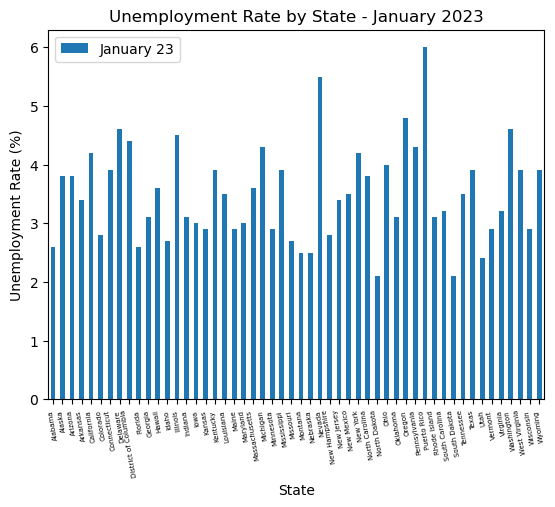

<Figure size 1500x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [176]:
# read in the excel file and skip the first row, set the second row as header
state_unp_rate_df = pd.read_excel("State_unemployement_rate.bls_table.xlsx", skiprows=1, header=1)

# set the 'State' column as the index
state_unp_rate_df.set_index('State', inplace=True)

# create a bar chart
ax = state_unp_rate_df.plot.bar(align="center")

# set the chart title and axis labels
ax.set_title('Unemployment Rate by State - January 2023')
ax.set_xlabel('State', fontsize=10)
ax.set_ylabel('Unemployment Rate (%)')
ax.tick_params(axis='x', labelsize=5, rotation=100)

# set the x-axis limits
ax.set_xlim([-0.5, len(state_unp_rate_df)-0.5])

# set the figure size
plt.figure(figsize=(15, 10))

# show the plot
plt.show()
plt.savefig("unemployment_rate.png")


In [177]:
#https://data.bls.gov/apps/covid-dashboard/home.htm
duration_unp_rate_df = pd.read_csv("duration_unemployment_bls_table.csv")
duration_unp_rate_df.head()

,Date,Less than 5 weeks,5-14 weeks,15-26 weeks,27 weeks and over
0,15-Jan,2393000,2319000,1377000,2774000
1,15-Feb,2392000,2238000,1333000,2658000
2,15-Mar,2444000,2304000,1245000,2542000
3,15-Apr,2716000,2345000,1091000,2560000
4,15-May,2471000,2510000,1256000,2503000


In [178]:
print(duration_unp_rate_df.dtypes)

Date                 object
Less than 5 weeks     int64
5-14 weeks            int64
15-26 weeks           int64
27 weeks and over     int64
dtype: object


In [179]:
#https://fred.stlouisfed.org/series/EXPINF10YR
expected_inflation_df = pd.read_excel("EXPINF10YR.xlsx", skiprows=9, header=1)
expected_inflation_df

,observation_date,EXPINF10YR
0,2010-01-01,2.091133
1,2010-02-01,2.016553
2,2010-03-01,2.006760
3,2010-04-01,2.063127
4,2010-05-01,2.023405
...,...,...
154,2022-11-01,2.454670
155,2022-12-01,2.219378
156,2023-01-01,2.285609
157,2023-02-01,2.105739


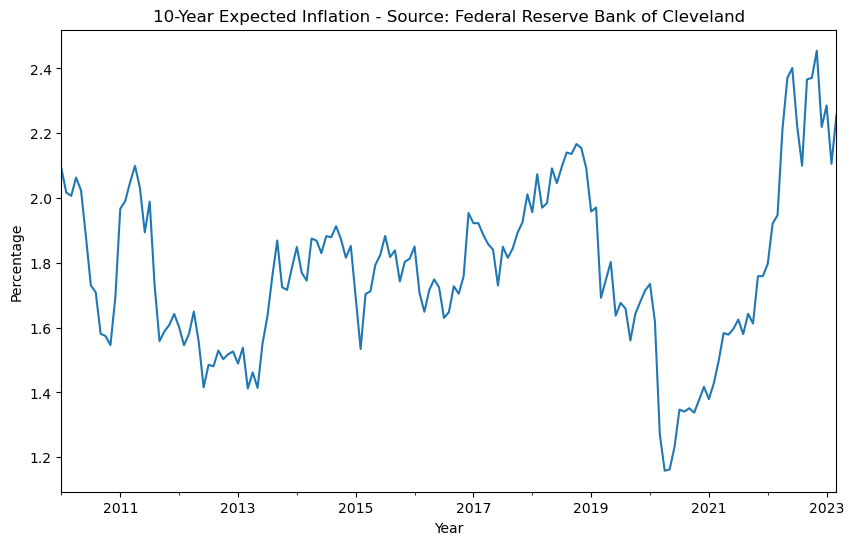

In [180]:

# Read the Excel file into a Pandas DataFrame
expected_inflation_df = pd.read_excel("EXPINF10YR.xlsx", skiprows=9, header=1)

# Convert the observation_date column to a datetime object
expected_inflation_df['observation_date'] = pd.to_datetime(expected_inflation_df['observation_date'])

# Set the observation_date column as the index of the DataFrame
expected_inflation_df.set_index('observation_date', inplace=True)

# Create a line plot of the EXPINF10YR column
expected_inflation_df['EXPINF10YR'].plot(figsize=(10, 6))

# Set the title and axis labels
plt.title('10-Year Expected Inflation - Source: Federal Reserve Bank of Cleveland')
plt.xlabel('Year')
plt.ylabel('Percentage')

# Save the plot as an image file
plt.savefig("expected_infl.png")

# Show the plot
plt.show()


In [181]:
# Sort the dataframe by 'EXPINF10YR' column
top_inflation_df = expected_inflation_df.sort_values(['EXPINF10YR'], ascending=False)

# Get the top 10 rows
top_inflation_df = top_inflation_df.head(10)

# Reset the index
top_inflation_df = top_inflation_df.reset_index()

# Convert the datetime column to only show the date
top_inflation_df['observation_date'] = top_inflation_df['observation_date'].dt.date


# Create the PrettyTable object
table = PrettyTable()

# Add the columns to the table
table.field_names = ["Date", "Top 10 Inflation Rate"]

# Add the rows to the table
for index, row in top_inflation_df.iterrows():
    table.add_row([row['observation_date'], round(row['EXPINF10YR'], 2)])

# Set the align of the columns
table.align["Date"] = "l"
table.align["Inflation Rate"] = "r"

# Print the table
print(table)

+------------+-----------------------+
| Date       | Top 10 Inflation Rate |
+------------+-----------------------+
| 2022-11-01 |          2.45         |
| 2022-06-01 |          2.4          |
| 2022-10-01 |          2.37         |
| 2022-05-01 |          2.37         |
| 2022-09-01 |          2.37         |
| 2023-01-01 |          2.29         |
| 2023-03-01 |          2.26         |
| 2022-07-01 |          2.22         |
| 2022-12-01 |          2.22         |
| 2022-04-01 |          2.21         |
+------------+-----------------------+


In [182]:
# Sort the dataframe by 'EXPINF10YR' column
bottom_inflation_df = expected_inflation_df.sort_values(['EXPINF10YR'], ascending=True)

# Get the top 10 rows
bottom_inflation_df = bottom_inflation_df.head(10)

# Reset the index
bottom_inflation_df = bottom_inflation_df.reset_index()

# Convert the datetime column to only show the date
bottom_inflation_df['observation_date'] = bottom_inflation_df['observation_date'].dt.date

# Create the PrettyTable object
table = PrettyTable()

# Add the columns to the table
table.field_names = ["Date", "Bottom 10 Inflation Rate"]

# Add the rows to the table
for index, row in bottom_inflation_df.iterrows():
    table.add_row([row['observation_date'], round(row['EXPINF10YR'], 2)])

# Set the align of the columns
table.align["Date"] = "l"
table.align["Inflation Rate"] = "r"

# Print the table
print(table)

+------------+--------------------------+
| Date       | Bottom 10 Inflation Rate |
+------------+--------------------------+
| 2020-04-01 |           1.16           |
| 2020-05-01 |           1.16           |
| 2020-06-01 |           1.23           |
| 2020-03-01 |           1.27           |
| 2020-10-01 |           1.34           |
| 2020-08-01 |           1.34           |
| 2020-07-01 |           1.35           |
| 2020-09-01 |           1.35           |
| 2020-11-01 |           1.38           |
| 2021-01-01 |           1.38           |
+------------+--------------------------+


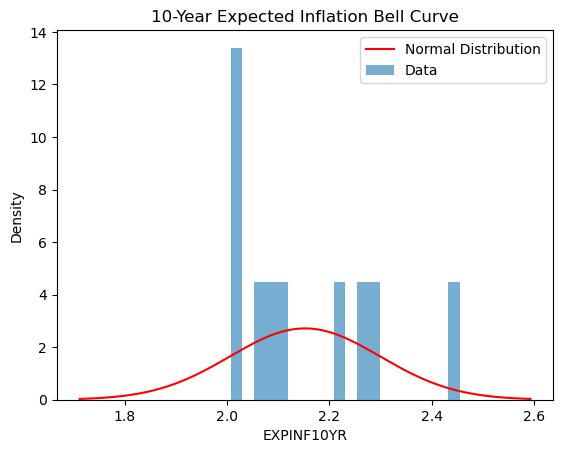

In [183]:
# Read the data from the Excel file
expected_inflation_df = pd.read_excel("EXPINF10YR.xlsx", skiprows=9, header=1)

# Set the observation_date column as the index of the DataFrame
expected_inflation_df.set_index('observation_date', inplace=True)

# Convert the observation_date column to a datetime object
expected_inflation_df.index = pd.to_datetime(expected_inflation_df.index)

# Calculate the mean and standard deviation of the data
mu = df['EXPINF10YR'].mean()
sigma = df['EXPINF10YR'].std()

# Create a normal distribution based on the mean and standard deviation
dist = stats.norm(mu, sigma)

# Generate 1000 values from the normal distribution
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = dist.pdf(x)

# Plot the bell curve
plt.plot(x, y, color='red', label='Normal Distribution')
plt.hist(df['EXPINF10YR'], bins=20, density=True, alpha=0.6, label='Data')
plt.legend()
plt.title('10-Year Expected Inflation Bell Curve')
plt.xlabel('EXPINF10YR')
plt.ylabel('Density')
plt.savefig('bell_curve.png')
plt.show()


In [184]:
#https://https://alfred.stlouisfed.org/series?seid=REAINTRATREARAT10Y
# Read the Excel file into a Pandas DataFrame
real_interest_df = pd.read_excel("10yrs_real_interest_rate_alfredgraph.xlsx", skiprows=10, header=1)
real_interest_df

,observation_date,REAINTRATREARAT10Y
0,2010-02-01,1.124515
1,2010-03-01,0.998732
2,2010-04-01,1.309105
3,2010-05-01,1.226388
4,2010-06-01,1.019361
...,...,...
153,2022-11-01,1.930713
154,2022-12-01,1.576125
155,2023-01-01,1.783099
156,2023-02-01,1.403694


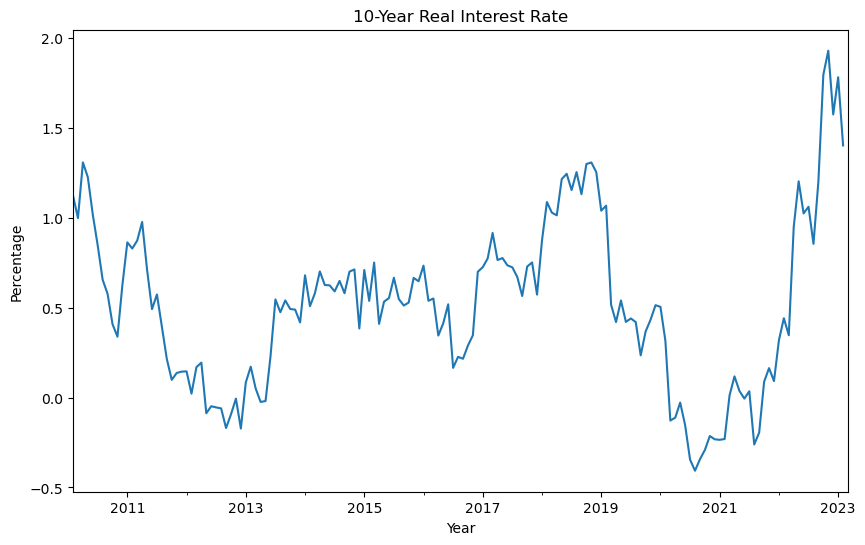

In [185]:
# Convert the observation_date column to a datetime object
real_interest_df['observation_date'] = pd.to_datetime(real_interest_df['observation_date'])

# Set the observation_date column as the index of the DataFrame
real_interest_df.set_index('observation_date', inplace=True)

# Create a line plot of the EXPINF10YR column
real_interest_df['REAINTRATREARAT10Y'].plot(figsize=(10, 6))

# Set the title and axis labels
plt.title('10-Year Real Interest Rate')
plt.xlabel('Year')
plt.ylabel('Percentage')

# Save the plot as an image file
plt.savefig("real_int_rate.png")

# Show the plot
plt.show()

In [186]:
# Sort the dataframe by 'EXPINF10YR' column
top_int_df = real_interest_df.sort_values(['REAINTRATREARAT10Y'], ascending=False)

# Get the top 10 rows
top_int_df = top_int_df.head(10)

# Reset the index
top_int_df = top_int_df.reset_index()

# Convert the datetime column to only show the date
top_int_df['observation_date'] = top_int_df['observation_date'].dt.date


# Create the PrettyTable object
table = PrettyTable()

# Add the columns to the table
table.field_names = ["Date", "Top 10 Real Interest Rate"]

# Add the rows to the table
for index, row in top_int_df.iterrows():
    table.add_row([row['observation_date'], round(row['REAINTRATREARAT10Y'], 2)])

# Set the align of the columns
table.align["Date"] = "l"
table.align["Real Interest Rate"] = "r"

# Print the table
print(table)

+------------+---------------------------+
| Date       | Top 10 Real Interest Rate |
+------------+---------------------------+
| 2022-11-01 |            1.93           |
| 2022-10-01 |            1.8            |
| 2023-01-01 |            1.78           |
| 2022-12-01 |            1.58           |
| 2023-02-01 |            1.4            |
| 2010-04-01 |            1.31           |
| 2018-11-01 |            1.31           |
| 2018-10-01 |            1.3            |
| 2018-08-01 |            1.26           |
| 2018-12-01 |            1.25           |
+------------+---------------------------+


In [187]:
# Sort the dataframe by 'EXPINF10YR' column
bottom_int_df = real_interest_df.sort_values(['REAINTRATREARAT10Y'], ascending=True)

# Get the top 10 rows
bottom_int_df = bottom_int_df.head(10)

# Reset the index
bottom_int_df = bottom_int_df.reset_index()

# Convert the datetime column to only show the date
bottom_int_df['observation_date'] = bottom_int_df['observation_date'].dt.date


# Create the PrettyTable object
table = PrettyTable()

# Add the columns to the table
table.field_names = ["Date", "Botton 10 Real Interest Rate"]

# Add the rows to the table
for index, row in bottom_int_df.iterrows():
    table.add_row([row['observation_date'], round(row['REAINTRATREARAT10Y'], 2)])

# Set the align of the columns
table.align["Date"] = "l"
table.align["Real Interest Rate"] = "r"

# Print the table
print(table)

+------------+------------------------------+
| Date       | Botton 10 Real Interest Rate |
+------------+------------------------------+
| 2020-08-01 |            -0.41             |
| 2020-07-01 |            -0.35             |
| 2020-09-01 |            -0.34             |
| 2020-10-01 |            -0.29             |
| 2021-08-01 |            -0.26             |
| 2021-01-01 |            -0.24             |
| 2020-12-01 |            -0.23             |
| 2021-02-01 |            -0.23             |
| 2020-11-01 |            -0.21             |
| 2021-09-01 |            -0.19             |
+------------+------------------------------+


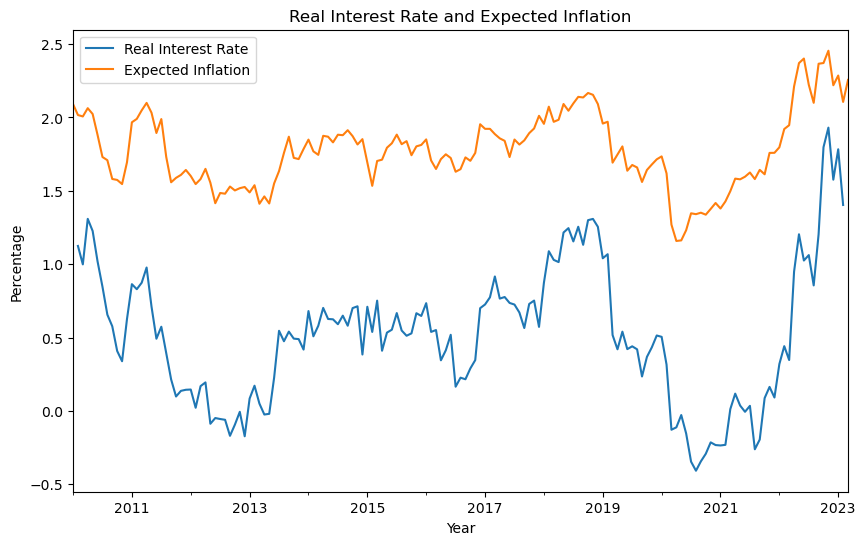

In [191]:
# # Read the Excel files into Pandas DataFrames
real_interest_df = pd.read_excel("10yrs_real_interest_rate_alfredgraph.xlsx", skiprows=10, header=1)
expected_inflation_df = pd.read_excel("EXPINF10YR.xlsx", skiprows=9, header=1)

# Convert the observation_date column to a datetime object and set it as the index of each DataFrame
real_interest_df['observation_date'] = pd.to_datetime(real_interest_df['observation_date'])
real_interest_df.set_index('observation_date', inplace=True)
expected_inflation_df['observation_date'] = pd.to_datetime(expected_inflation_df['observation_date'])
expected_inflation_df.set_index('observation_date', inplace=True)

# Create a line plot of both columns
ax = real_interest_df['REAINTRATREARAT10Y'].plot(figsize=(10, 6))
expected_inflation_df['EXPINF10YR'].plot(ax=ax)

# Set the title and axis labels
plt.title('Real Interest Rate and Expected Inflation')
plt.xlabel('Year')
plt.ylabel('Percentage')

# Add a legend for the two lines
plt.legend(['Real Interest Rate', 'Expected Inflation'])

# Save the plot as an image file
plt.savefig("infl_and_real.png")

# Show the plot
plt.show()

